# Actor-Critic Methods

**Background**:
In this practical we will train an agent using the Actor-Critic algorithm to learn to balance a pole in the OpenAI gym [Cartpole environment](https://gym.openai.com/envs/CartPole-v1).

**Learning objectives**:
* Understand the Actor-Critic approach to directly training a parameterised policy and state-value function to maximise expected future rewards.

**What is expected of you**:
 * Go through the explanation, keeping the above learning objectives in mind.
 * Fill in the missing code ("#IMPLEMENT-ME") and train a model to solve the Cartpole-v1 environment in OpenAI gym (you solve it when reward=500).

## Introduction

Although the REINFORCE-with-baseline method learns both a policy and a state-value function, we do not consider it to be an actor–critic method because its state-value function is used only as a baseline, not as a critic. That is, it is not used for bootstrapping (updating the value estimate for a state from the estimated values of subsequent states), but only as a baseline for the state whose estimate is being updated. This is a useful distinction, for only through bootstrapping do we introduce bias and an asymptotic dependence on the quality of the function approximation. As we have seen, the bias introduced through bootstrapping and reliance on the state representation is often beneficial because it reduces variance and accelerates learning. REINFORCE with baseline is unbiased and will converge asymptotically to a local minimum, but like all Monte Carlo methods it tends to learn slowly (produce estimates of high variance) and to be inconvenient to implement online or for continuing problems. Temporal-difference methods we can eliminate these inconveniences, and through multi-step methods we can flexibly choose the degree of bootstrapping. In order to gain these advantages in the case of policy gradient methods we use actor–critic methods with a bootstrapping critic.

![Actor-Critic Model](https://raw.githubusercontent.com/andrecianflone/rl_at_ammi/master/images/Policy-iteration-and-actor-critic-learning.png "Actor-Critic Model")


**NOTE**: 

* Combine ideas from policy and value function methods
* Actor improvement - Policy parameterised by $\pi$
* Critic evaluation - Value function parameterised by $\omega$
    - Either $V(s; \omega)$ or $Q(s, a; \omega)$
    
**Actor-Critic pseudocode**:

Input: parameterised forms for $\pi_{\theta}(s|a)$ and $V_{\omega}(s)$
<br>
Input: learning rates $\alpha_{\omega} > 0$ and $\alpha_{\theta} > 0$

For each episode:<br>
$\quad$ Initialise $s$<br>
$\quad$ For each time step:<br>
$\quad \quad$Choose $a \sim \pi_{\theta}(s|a)$<br>
$\quad \quad$Take $a$, observe $s′$, $𝑟$<br>
$\quad \quad \delta \leftarrow r + \gamma V_{\omega}(s′) - V_{\omega}(s)$<br>
$\quad \quad \omega \leftarrow \omega + \alpha_{\omega} \delta \nabla_{\omega} V_{\omega}(𝑠)$<br>
$\quad \quad \theta \leftarrow \theta + \alpha_{\theta} \delta \nabla_{\theta} \log\pi_\theta(a|s)$<br>
$\quad \quad s \leftarrow s'$<br>
 

In [1]:
!pip install box2d-py

In [2]:
from __future__ import absolute_import, division, print_function
import gym
import numpy as np
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical 

# for auto-reloading external modules
# (if you're curious, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

In [3]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## The Environment

In [4]:
from multiprocessing_env import SubprocVecEnv

num_envs = 8
env_name = "CartPole-v1"

def make_env(seed, rank):
    def _thunk():
        env = gym.make(env_name)
        env.seed(seed+rank)
        return env

    return _thunk

env = gym.make(env_name)
env.seed(111)
print('action space:', env.action_space)
print('observation space:', env.observation_space)

action space: Discrete(2)
observation space: Box(4,)


/Users/shahil/miniconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Watching a random policy agent play

Let's also see how a random policy performs in this enviroment:

In [5]:
# state = env.reset()
# for t in range(150):
#     # sample a random action
#     action = env.action_space.sample()
#     env.render()
#     state, reward, done, _ = env.step(action)

Not very good! ... Now let's improve things using Actor-Critic.

## The Actor-Critic Networks

Simple enough. Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html)

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [7]:
def test_env(model, vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20.0, 10.0))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

### Selecting actions with our Actor network

For a given state our networks returns a pytorch `Categorial` object along with the `value` object. We can sample from this distribution by calling it's `sample` method and we can find the log probability of an action using `log_prob`:

In [9]:
actorCritic = ActorCritic(env.observation_space.shape[0], env.action_space.n, 256).to(device)
state = env.reset()
state = torch.from_numpy(state).float().to(device)
dist, value = actorCritic(state)
action = dist.sample()
print("Sampled action:", action.item())
print("Log probability of action:", dist.log_prob(action).item())
print("Value:", value.item())

Sampled action: 0
Log probability of action: -0.6562356352806091
Value: -0.0125521719455719


/Users/shahil/miniconda3/envs/rl/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Computing the return
Calculate the return $\sum_{t=0}^T r_t + \gamma^t  V_{\omega}(s_{t+1})$.

In [10]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

## Actor-Critic

Now its time to implement the algorithm

**Actor-Critic pseudocode**:

Input: parameterised forms for $\pi_{\theta}(s|a)$ and $V_{\omega}(s)$
<br>
Input: learning rates $\alpha_{\omega} > 0$ and $\alpha_{\theta} > 0$


Initialise $s$<br>
For each time step:<br>
$ \quad$Choose $a \sim \pi_{\theta}(s|a)$<br>
$ \quad$Take $a$, observe $s′$, $𝑟$<br>
$ \quad \delta \leftarrow r + \gamma V_{\omega}(s′) - V_{\omega}(s)$<br>
$ \quad \omega \leftarrow \omega + \alpha_{\omega} \delta \nabla_{\omega} V_{\omega}(𝑠)$<br>
$ \quad \theta \leftarrow \theta + \alpha_{\theta} \delta \nabla_{\theta} \log\pi_\theta(a|s)$<br>
$ \quad s \leftarrow s'$<br>

### Hyperameters

In [11]:
hidden_size = 256
learning_rate = 3e-4
num_step_td_update = 5
max_steps = 100000

In [14]:
def actor_critic(seed, verbose=True):
    
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    envs = [make_env(seed, i) for i in range(num_envs)]
    envs = SubprocVecEnv(envs)
    
    # instantiate the policy and optimiser
    num_inputs  = envs.observation_space.shape[0]
    num_outputs = envs.action_space.n
    model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    current_step_number = 0
    test_rewards = []
    state = envs.reset()
    
    while current_step_number < max_steps:
        
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(num_step_td_update):
            # get the distribution over actions for state and the value of the state
            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)
            
            # sample an action from the distribution
            action = dist.sample()
            # take a step in the environment
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
                
            # compute the log probability
            log_prob = dist.log_prob(action)
            # compute the entropy
            entropy += dist.entropy().mean()
            
            # save the log probability, value and reward 
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            state = next_state
            current_step_number += 1
            
            if current_step_number % 1000 == 0:
                test_rewards.append(np.mean([test_env(model) for _ in range(10)]))
                plot(current_step_number, test_rewards)

        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = model(next_state)
   
        # calculate the discounted return of the episode
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values)

        advantage = returns - values

        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

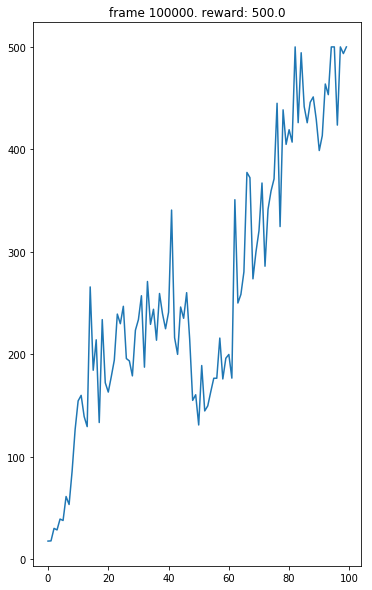

In [15]:
env.seed(945)
model = actor_critic(345)

## Seeing our learned policy in action

Let's watch our agent!

In [17]:
state = env.reset()
for t in range(2000):
    dist, _ = model(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env.render()
    state, reward, done, _ = env.step(action.item())
    if done:
        break

## References

- Reinforcement Learning: An Introduction [Book](http://incompleteideas.net/book/bookdraft2017nov5.pdf)
- Policy Gradient [Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic)